In [1]:
import os
import shutil
import random 

import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision import transforms,datasets
from torch.utils.data import DataLoader



/Users/karliekaz/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set the main directory
main_directory = "MP3_train_test_sets_2"
maincat_directory = "Micro_Organism"


# Create train and test directories
train_directory = os.path.join(main_directory, "train")
test_directory = os.path.join(main_directory, "test")
extratest_directory = os.path.join(main_directory, "extra_test")


# Iterate through each category
for category in os.listdir(maincat_directory):
    category_path = os.path.join(maincat_directory, category)
    
    # Create subdirectories for each category
    train_category_path = os.path.join(train_directory, category)
    test_category_path = os.path.join(test_directory, category)
    extratest_category_path = os.path.join(extratest_directory, category)
    
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)
    os.makedirs(extratest_category_path, exist_ok=True)
    
    #list of all images in the category
    images = os.listdir(category_path)
    
    # Take 5 random images for the test 
    test_images = random.sample(images, 5)

    #take 1 image from each to set aside for testing 
    extratest_images = random.sample(images, 1)

    
    for image in images:
        image_path = os.path.join(category_path, image)
        
        # Copy images to train or test directory based on the split
        if image in test_images:
            shutil.copy(image_path, os.path.join(test_category_path, image))
        elif image in extratest_images:
            shutil.copy(image_path, os.path.join(extratest_category_path, image))
        else:
            shutil.copy(image_path, os.path.join(train_category_path, image))

print("Dataset split into train and test sets")

Dataset split into train and test sets


In [3]:

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
#set up transforms 

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), #  Reshape all images to 224x224 
    transforms.ToTensor(), #Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] 
                         std=[0.229, 0.224, 0.225]) # A standard deviation of [0.229, 0.224, 0.225] 
])

In [6]:
# Set path

train = 'MP3_train_test_sets_2/train'
test = 'MP3_train_test_sets_2/test'

# Use ImageFolder to create the train and test data

train_data = datasets.ImageFolder(train,transform=manual_transforms)
test_data = datasets.ImageFolder(test, transform=manual_transforms)

In [7]:
# Create dataloaders
num_workers = 8
batch_size = 16     #smaller batch size because of amount of data 

class_names = train_data.classes
print(f"Classes in this dataset: {class_names}")

train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)

Classes in this dataset: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


In [8]:

from transformers import AutoImageProcessor, ViTModel
from transformers import ViTImageProcessor, ViTForImageClassification

#model from documentation : https://huggingface.co/google/vit-base-patch16-224

# initiate model from pretrained 
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


In [9]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
#check for linear layer 

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViTForImageClassification (ViTForImageClassification)                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─ViTModel (vit)                                                       [32, 3, 224, 224]    [32, 197, 768]       --                   True
│    └─ViTEmbeddings (embeddings)                                      [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [32, 3, 224, 224]    [32, 196, 768]       590,592              True
│    │    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
│    └─ViTEncoder (encoder)                                            [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─ModuleList (

In [10]:
for param in model.parameters():
    param.requires_grad = False
    
#modify last classifier layer for new out features 
model.classifier = nn.Linear(in_features=768, out_features=len(class_names), bias=True).to(device)

In [11]:
from torchinfo import summary

# Print a summary 
summary(model=model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
ViTForImageClassification (ViTForImageClassification)                  [32, 3, 224, 224]    [32, 8]              --                   Partial
├─ViTModel (vit)                                                       [32, 3, 224, 224]    [32, 197, 768]       --                   False
│    └─ViTEmbeddings (embeddings)                                      [32, 3, 224, 224]    [32, 197, 768]       152,064              False
│    │    └─ViTPatchEmbeddings (patch_embeddings)                      [32, 3, 224, 224]    [32, 196, 768]       (590,592)            False
│    │    └─Dropout (dropout)                                          [32, 197, 768]       [32, 197, 768]       --                   --
│    └─ViTEncoder (encoder)                                            [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─Modul

In [12]:

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()



# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        average_val_loss = val_loss / len(test_dataloader)
        accuracy = correct / total

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_val_loss:.4f}, Accuracy: {accuracy:.4%}')



Epoch [1/5], Loss: 0.9905, Accuracy: 67.9487%
Epoch [2/5], Loss: 0.8434, Accuracy: 74.3590%
Epoch [3/5], Loss: 0.7152, Accuracy: 78.2051%
Epoch [4/5], Loss: 0.6441, Accuracy: 79.4872%
Epoch [5/5], Loss: 0.5991, Accuracy: 80.7692%


In [13]:
# Save the fine-tuned model checkpoint
torch.save(model.state_dict(), 'vit_model.pth')

In [18]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "vit_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)

Predicted class: Hydra, Probability: 0.9984


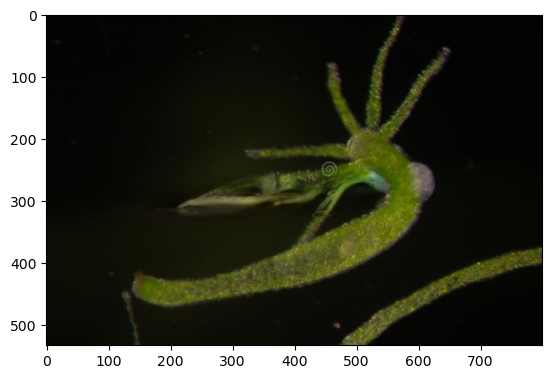

In [19]:
import requests
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as Funct


# lets test out the model with one of the extra-test images we set aside: 


# Setup image path

image_path = 'MP3_train_test_sets_2/extra_test/Hydra/Image_94.jpg'
input_image = Image.open(image_path)
input_tensor = manual_transforms(input_image)
input_batch = input_tensor.unsqueeze(0)

# Make prediction
with torch.no_grad():
    outputs = model(input_batch).logits
    probabilities = Funct.softmax(outputs, dim=1)

# get the prediction and probability
predicted_class = torch.argmax(probabilities).item()
pred = class_names[predicted_class]
predicted_probability = probabilities[0, predicted_class].item()

# Display the image with prediction and accuracy
print(f'Predicted class: {pred}, Probability: {predicted_probability:.4f}')
plt.imshow(input_image)
plt.show()


1. What did you enjoy about the course?
- I very much enjoyed this course! I found it extremely challenging but also rewarding. I enjoyed learning about unsupervised learning because it is very interesting, new, and revolutionary. Although it is a difficult topic, I found it beneficial to learn how it works conceptually since it can be aaplied to many applications. 

2. What was the biggest takeaway for you from the course?
- My biggest takeaway is that machine learning and AI are obtainable concepts to learn and understand. Machine Learning, when advertised, seems like a very complex tast that would be impossible to replicate, but through this class, it has proven that even I, who does not have extensive training in code, can learn and understand ML. I now have a toolset of skills that can be deployed to aid in simple tasks like classification, translation, summarization, etc. 


3. What feedback do you have for the professor in terms of improvements?
- I liked the structure of the class. The only improvement that I have is that I wish there was office hours. I would come across errors and get stuck, so being able to talk it through with another person would have helped me greatly. 